In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install hdf5storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
!unzip '/content/drive/MyDrive/NNDL_HWe_Q4/train_val.zip' '/content/drive/MyDrive/NNDL_HWe_Q4/train_val'
!unzip '/content/drive/MyDrive/NNDL_HWe_Q4/TEST.zip' '/content/drive/MyDrive/NNDL_HWe_Q4/TEST'

unzip:  cannot find or open /content/drive/MyDrive/NNDL_HWe_Q4/train_val.zip, /content/drive/MyDrive/NNDL_HWe_Q4/train_val.zip.zip or /content/drive/MyDrive/NNDL_HWe_Q4/train_val.zip.ZIP.


<div dir='rtl'>
<B>
دانلود دیتاست تصاویر پزشکی تومور مغری
</B>
</div>

In [ ]:
import os
import sys
import numpy as np
import hdf5storage
import cv2

labels = []
images = []
masks = []

path='brain_tumor_dataset'
image_dimension=512
data_dir = '/content/drive/MyDrive/NNDL_HWe_Q4/TEST/'

files = os.listdir(data_dir)
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(image_dimension, image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(image_dimension, image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    labels.append(int(mat_file[0])-1)
    images.append(image)
    masks.append(mask.astype(bool))

sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

np.save(os.path.join(path, 'labels.npy'), labels)
np.save(os.path.join(path, 'images.npy'), images)
np.save(os.path.join(path, 'masks.npy'), masks)

print('labels.npy, images.npy, masks.npy saved in', path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/NNDL_HWe_Q4/TEST/'

<div dir='rtl'>
تغییر ابعاد دیتاست و مشاهده آن
</div>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.load('brain_tumor_dataset/images.npy')
masks = np.load('brain_tumor_dataset/masks.npy')*1
images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

print(labels.shape)
print(images.shape)
print(masks.shape)

<div dir='rtl'>
نمایش چند نمونه داده ( تصویر و mask ) به همراه label آن
</div>

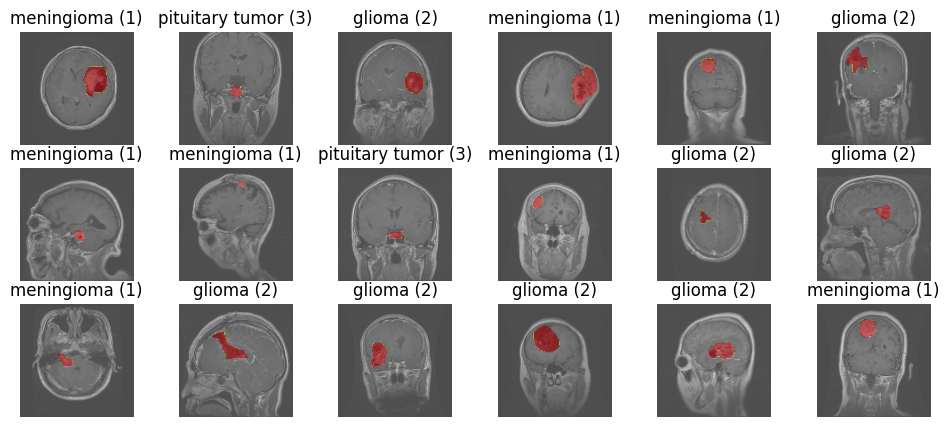

In [ ]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Train Image and its mask which is to be predicted

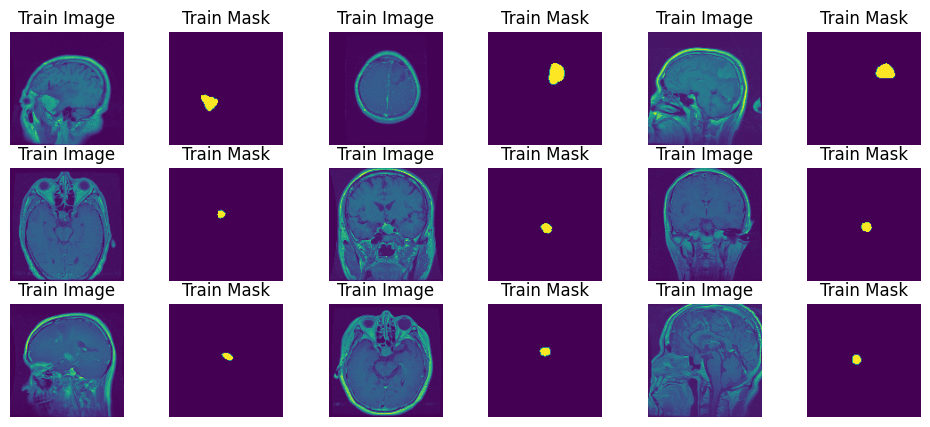

In [ ]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1))
  plt.title("Train Mask")
  plt.axis('off')

تقسیم داده به train , test

In [ ]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( images,labels,test_size=0.2,stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_v.shape

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
Y.shape

(2451,)

### Augmentation

افزایش داده

In [ ]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

تعریف Generator برای train , val

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

### Defining Dice Loss
Dice = 2|A∩B|/|A|+|B|

In [ ]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true=(float)(y_true)
    y_pred=(float)(y_pred)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (128,128,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu", name=name+'_1')(input_tensor)

  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu",name=name+'_2')(x)
  return x


inp = Input( shape=IMG_DIM )

d1 = conv2d_block( inp, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
#p1 = Dropout(0.1)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
#p2 = Dropout(0.1)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
#p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p1,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
#p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
#u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
#u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
#u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
#u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c4)

unet = Model( inp, out )
unet.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 128, 128, 256), (None, 32, 32, 256)]

### Defining IOU metric and compile Model

In [ ]:
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def iou_metric(label, pred):
    return tf.numpy_function(get_iou_vector, [label, pred>0.5], tf.float64)

unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
             loss=bce_dice_loss, metrics=['accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_v, Y_v, batch_size=32)

hist = unet.fit(X,Y,batch_size=32,epochs=50,
               validation_data=(X_v,Y_v),verbose=1)

unet = load_model('model_best_checkpoint.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric}) #or compile = False

Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 13.0575 - accuracy: 0.9544 - iou_metric: 0.0201
Epoch 1: val_loss improved from inf to 1.43625, saving model to model_best_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 92s 730ms/step - loss: 13.0575 - accuracy: 0.9544 - iou_metric: 0.0201 - val_loss: 1.4362 - val_accuracy: 0.9718 - val_iou_metric: 0.0407 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 1.3068 - accuracy: 0.9683 - iou_metric: 0.0603
Epoch 2: val_loss improved from 1.43625 to 1.11063, saving model to model_best_checkpoint.h5
77/77 [==============================] - 34s 436ms/step - loss: 1.3068 - accuracy: 0.9683 - iou_metric: 0.0603 - val_loss: 1.1106 - val_accuracy: 0.9720 - val_iou_metric: 0.0966 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.9704 - iou_metric: 0.0950
Epoch 3: val_loss improved from 1.11063 to 1.06571, saving model to model_best_checkpoint.h5
77/77 [==============================] - 33s 434ms/step - loss: 1.0969 - accuracy: 0.9704 - iou_metric: 0.0950 - val_loss: 1.0657 - val_accuracy: 0.9750 - val_iou_metric: 0.0979 - lr: 0.0010
Epoch 4/50

In [ ]:
Y.shape

(2451, 128, 128, 1)

KeyError: 'acc'

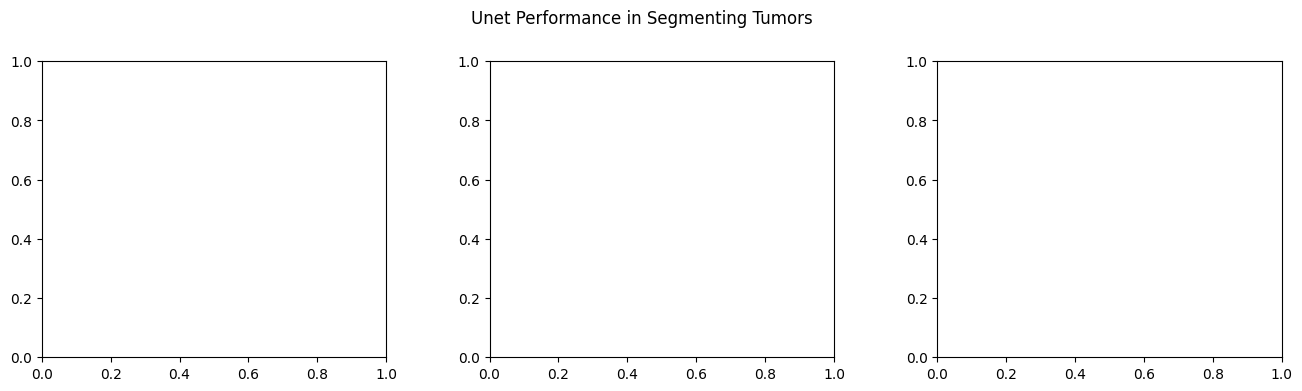

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

In [ ]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(X_v)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[idx],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()

In [ ]:
#Initial  BLock of the model
ini_input=keras.Input(shape=(512,512,1),name="image")

x1=layers.Conv2D(64,(22,22),strides=2)(ini_input)
x1=layers.MaxPooling2D((4,4))(x1)
x1=layers.BatchNormalization()(x1)

x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
x2=layers.MaxPooling2D((2,2))(x2)
x2=layers.BatchNormalization()(x2)

x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
x3=layers.MaxPooling2D((2,2))(x3)
x3=layers.BatchNormalization()(x3)

x4=layers.Flatten()(x3)
x4=layers.Activation("relu")(x4)

x5=layers.Dense(1024,"relu")(x4)

x6=layers.Dense(256,"relu")(x5)

x9=layers.Dense(3)(x6)
pred=layers.Activation("softmax")(x9)

model=keras.Model(inputs=ini_input,outputs=pred)

model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model.fit(X,Y,epochs=20,batch_size=32,shuffle=False)

NameError: name 'X' is not defined

In [ ]:
X

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   5,   3,   3],
        ...,
        [  0,   0,   2, ...,   4,   4,   4],
        [  0,   0,   0, ...,   3,   2,   3],
        [  0,   0,   0, ...,   2,   1,   1]],

       [[  0,   0,   0, ...,   1,   0,   0],
        [  0,   0,   0, ...,   1,   1,   0],
        [  0,   0,   0, ...,   6,   4,   4],
        ...,
        [  0,   0,   0, ...,   7,   7,   8],
        [  0,   0,   0, ...,   4,   5,   5],
        [  0,   0,   0, ...,   4,   4,   5]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   1, ...,   1,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,  16,  22,  26],
        [  0,   0,   0, ...,  15,  18,  19],
        [  0,   0,   0, ...,  17,  16,  16